# LIBRARY

In [29]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import date, datetime
from multiprocessing.spawn import import_main_path
from keras.preprocessing.sequence import TimeseriesGenerator
from pandas_datareader import data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np

from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D




# GET DATA

In [30]:
tickers = ["ANTM.JK","ASII.JK","ICBP.JK","JSMR.JK"]

today = date.today()
# print(today)
start_date = '2010-01-01'
# end_date = '2022-08-02'

panel_data = data.DataReader(tickers,'yahoo',start_date,today)
panel_data.head(5)


Attributes    Adj Close                                               Close  \
Symbols         ANTM.JK      ASII.JK      ICBP.JK      JSMR.JK      ANTM.JK   
Date                                                                          
2010-01-04  1576.277222  2454.149414  1408.558960  1530.937744  1931.946777   
2010-01-05  1576.277222  2468.053955  1437.305298  1547.488770  1931.946777   
2010-01-06  1576.277222  2454.149414  1427.723145  1555.763916  1931.946777   
2010-01-07  1610.544189  2377.673828  1437.305298  1547.488770  1973.945557   
2010-01-08  1610.544189  2391.578613  1446.887207  1539.213135  1973.945557   

Attributes                                      High          ...     Low  \
Symbols    ASII.JK ICBP.JK      JSMR.JK      ANTM.JK ASII.JK  ... ICBP.JK   
Date                                                          ...           
2010-01-04  3530.0  1837.5  1845.677368  1931.946777  3550.0  ...  1762.5   
2010-01-05  3550.0  1875.0  1865.630737  1994.945068  3570.0  ...  1825.0   
2010-01-06  3530.0  1862.5  1875.607300  1994.945068  3580.0  ...  1862.5   
2010-01-07  3420.0  1875.0  1865.630737  1994.945068  3560.0  ...  1862.5   
2010-01-08  3440.0  1887.5  1855.654053  1994.945068  3450.0  ...  1862.5   

Attributes                      Open                                   Volume  \
Symbols         JSMR.JK      ANTM.JK ASII.JK ICBP.JK      JSMR.JK     ANTM.JK   
Date                                                                            
2010-01-04  1805.770874  1931.946777  3530.0  1787.5  1845.677368  39619544.0   
2010-01-05  1845.677368  1931.946777  3550.0  1875.0  1865.630737  62041590.0   
2010-01-06  1855.654053  1931.946777  3530.0  1900.0  1875.607300  30916328.0   
2010-01-07  1845.677368  1973.945557  3420.0  1875.0  1865.630737  30624653.0   
2010-01-08  1845.677368  1973.945557  3440.0  1900.0  1855.654053  15857579.0   

Attributes                                 
Symbols    ASII.JK     ICBP.JK    JSMR.JK  
Date                                       
2010-01-04    40.0  26442000.0  6978806.0  
2010-01-05    40.0  42874000.0  7988164.0  
2010-01-06    40.0  44946000.0  7538113.0  
2010-01-07    40.0  24863000.0  2048787.0  
2010-01-08    40.0  19118000.0  2441705.0  

[5 rows x 24 columns]

In [31]:
data_close = panel_data["Adj Close"]
data_close.head(5).round(2)
list(data_close)
data_close.columns = ['antm', 'asii', 'icbp', 'jsmr']
data_close

,antm,asii,icbp,jsmr
Date,,,,
2010-01-04,1576.277222,2454.149414,1408.558960,1530.937744
2010-01-05,1576.277222,2468.053955,1437.305298,1547.488770
2010-01-06,1576.277222,2454.149414,1427.723145,1555.763916
2010-01-07,1610.544189,2377.673828,1437.305298,1547.488770
2010-01-08,1610.544189,2391.578613,1446.887207,1539.213135
...,...,...,...,...
2022-08-10,2120.000000,6850.000000,8725.000000,3450.000000
2022-08-11,2240.000000,6950.000000,8875.000000,3550.000000
2022-08-12,2220.000000,6950.000000,8675.000000,3490.000000


# Normalize data

In [32]:
from sklearn.preprocessing import MinMaxScaler
def normalize_data(df_data, COLUMN_NAME):
    scaler = MinMaxScaler()
    df_data = pd.DataFrame(df_data)
    df_data = pd.DataFrame(scaler.fit_transform(df_data), columns = [COLUMN_NAME])
    return df_data


In [33]:
df_asii = normalize_data(data_close.asii,'asii')
df_icbp = normalize_data(data_close.icbp, 'icbp')
df_jsmr = normalize_data(data_close.jsmr, 'jsmr')

# SLIDING WINDOW FUNCTION

In [34]:
from numpy import array

def split_sequence(seq, n_steps):
    X,y = list(), list()
    for i in range(len(seq)):
        end_ix = i + n_steps
        if end_ix > len(seq)-1:
            break
        seq_x, seq_y =seq[i:end_ix],seq[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# RESET INDEX FUNCTION

In [35]:
from sklearn.model_selection import train_test_split
def reset_index_data(df_data):
    df_data = df_data.reset_index(drop=True)
    arr_df = df_data.to_numpy()
    flat_df = arr_df.flatten()
    return flat_df

# RESHAPE DATA FUNC

In [36]:
def reshape_data(X,N_FEATURES):
    X = X.reshape(X.shape[0],X.shape[1],N_FEATURES)
    return X

# TRAIN VANILA MODEL FUCTION

In [37]:
def train_lstm(X_train,y_train,config):
    #unpach config
    neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_vanila_lstm = Sequential([
    LSTM(neuron, activation=activation,input_shape=(n_steps, n_features)),
    Dense(1),
    ])
    model_vanila_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    model_vanila_lstm.summary()
    history_vanila_lstm = model_vanila_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          shuffle = True
    )

    return model_vanila_lstm, history_vanila_lstm

#time 41.8
    

In [38]:
def train_vanila_lstm(X_train,y_train,config):
    #unpach config
    neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_vanila_lstm = Sequential([
    LSTM(neuron, activation=activation,input_shape=(n_steps, n_features)),
    Dense(1),
    ])
    model_vanila_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_vanila_lstm.summary()
    history_vanila_lstm = model_vanila_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_vanila_lstm, history_vanila_lstm

#time 41.8
    

# MATRICS EVALUTE

In [39]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
def matriks_evaluate(preds,y_test, lb_saham):
    print('Matriks score for '+ lb_saham)
    print("mae score: "+str(mean_absolute_error(preds, y_test)))
    print("r2 score "+str(r2_score(preds, y_test)))
    print("mape score "+str(mean_absolute_percentage_error(preds, y_test)))
    print("rmse score "+str(np.sqrt(mean_squared_error(preds, y_test))))

# ROUNDUP FUNCTION

In [40]:
def pembulatan(data,number):
    print(np.round(data,number))

# VANILA LSTM

## ANTM

In [41]:
#get data and normalize data
df_antm = normalize_data(data_close.antm,'antm')
#reset index
df_antm = reset_index_data(df_antm)
#data to supervised
antm_X, antm_y = split_sequence(df_antm, 2)
#split to train and test
X_train_antm, X_test_antm, y_train_antm, y_test_antm = train_test_split(antm_X, antm_y, test_size=0.33, random_state=42)

X_train_antm = reshape_data(X_train_antm,1)
X_test_antm = reshape_data(X_test_antm,1)


In [42]:
cfg_antm = [8,'relu',2,1,0.1,8,200]
model_antm,history_antm_model,  = train_vanila_lstm(X_train_antm,y_train_antm,cfg_antm)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 8)                 320       
                                                                 
 dense_6 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
210/210 [==============================] - 3s 4ms/step - loss: 0.0422 - mae: 0.0422 - val_loss: 0.0475 - val_mae: 0.0475
Epoch 2/200
210/210 [==============================] - 1s 3ms/step - loss: 0.0194 - mae: 0.0194 - val_loss: 0.0274 - val_mae: 0.0274
Epoch 3/200
210/210 [==============================] - 1s 3ms/step - loss: 0.0295 - mae: 0.0295 - val_loss: 0.0928 - val_mae: 0.0928
Epoch 4/200
210/210 [==============================] 

In [43]:
preds_antm = model_antm.predict(X_test_antm)
matriks_evaluate(preds_antm,y_test_antm,'antm')

Matriks score for antm
mae score: 0.008079814308692248
r2 score 0.9945805585150753
mape score 0.04029460103718889
rmse score 0.014598072272197404


In [44]:
# Matriks score for antm
pembulatan(0.007934620954499606,4)
pembulatan(0.9957026171046904,4)
pembulatan(0.04075884954250871,4)
pembulatan(0.01301039855428923,4)

0.0079
0.9957
0.0408
0.013


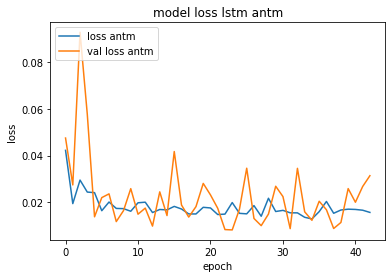

In [45]:
plt.plot(history_antm_model.history['loss'], label='loss antm')
plt.plot(history_antm_model.history['val_loss'], label = 'val loss antm')
plt.title('model loss lstm antm')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_antm', dpi=3600)

## ASII

In [46]:
#get data and normalize data
df_asii = normalize_data(data_close.asii,'asii')
#reset index
df_asii = reset_index_data(df_asii)
#data to supervised
asii_X, asii_y = split_sequence(df_asii, 3)
#split to train and test
X_train_asii, X_test_asii, y_train_asii, y_test_asii = train_test_split(asii_X, asii_y, test_size=0.33, random_state=42)

X_train_asii = reshape_data(X_train_asii,1)
X_test_asii = reshape_data(X_test_asii,1)


In [47]:
cfg_asii = [32,'relu',3,1,0.01,8,150]
model_asii,history_asii_model,  = train_vanila_lstm(X_train_asii,y_train_asii,cfg_asii)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 32)                4352      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
210/210 [==============================] - 2s 4ms/step - loss: 0.0562 - mae: 0.0562 - val_loss: 0.0258 - val_mae: 0.0258
Epoch 2/150
210/210 [==============================] - 1s 4ms/step - loss: 0.0238 - mae: 0.0238 - val_loss: 0.0286 - val_mae: 0.0286
Epoch 3/150
210/210 [==============================] - 1s 3ms/step - loss: 0.0239 - mae: 0.0239 - val_loss: 0.0204 - val_mae: 0.0204
Epoch 4/150
210/210 [============================

In [48]:
preds_asii = model_asii.predict(X_test_asii)
matriks_evaluate(preds_asii,y_test_asii,'asii')

Matriks score for asii
mae score: 0.014908565628717467
r2 score 0.9902509553762698
mape score 0.03312147905833175
rmse score 0.01975851413017389


In [49]:
# Matriks score for asii
pembulatan(0.014477178205400888,4)
pembulatan(0.9906708116313951,4)
pembulatan(0.03233571113583237,4)
pembulatan(0.019196850071116774,4)

0.0145
0.9907
0.0323
0.0192


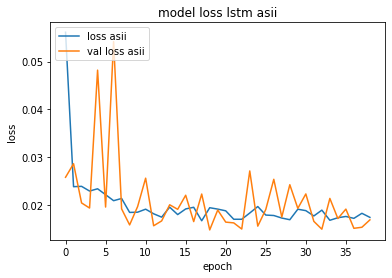

In [50]:
plt.plot(history_asii_model.history['loss'], label='loss asii')
plt.plot(history_asii_model.history['val_loss'], label = 'val loss asii')
plt.title('model loss lstm asii')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_asii', dpi=3600)

## ICBP


In [51]:
#get data and normalize data
df_icbp = normalize_data(data_close.icbp,'icbp')
#reset index
df_icbp = reset_index_data(df_icbp)
#data to supervised
icbp_X, icbp_y = split_sequence(df_icbp, 1)
#split to train and test
X_train_icbp, X_test_icbp, y_train_icbp, y_test_icbp = train_test_split(icbp_X, icbp_y, test_size=0.33, random_state=42)

X_train_icbp = reshape_data(X_train_icbp,1)
X_test_icbp = reshape_data(X_test_icbp,1)


In [52]:
# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_icbp = [8,'relu',1,1,0.01,16,200]
model_icbp,history_icbp_model,  = train_vanila_lstm(X_train_icbp,y_train_icbp,cfg_icbp)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 8)                 320       
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
105/105 [==============================] - 2s 6ms/step - loss: 0.1249 - mae: 0.1249 - val_loss: 0.0243 - val_mae: 0.0243
Epoch 2/200
105/105 [==============================] - 0s 4ms/step - loss: 0.0239 - mae: 0.0239 - val_loss: 0.0204 - val_mae: 0.0204
Epoch 3/200
105/105 [==============================] - 0s 3ms/step - loss: 0.0208 - mae: 0.0208 - val_loss: 0.0154 - val_mae: 0.0154
Epoch 4/200
105/105 [==============================] 

In [53]:
preds_icbp = model_icbp.predict(X_test_icbp)
matriks_evaluate(preds_icbp,y_test_icbp,'icbp')

Matriks score for icbp
mae score: 0.007210818142503178
r2 score 0.9983493350968135
mape score 0.028732106993582814
rmse score 0.011285054553547974


In [54]:
# Matriks score for icbp
pembulatan(0.007518278165003873
,4)
pembulatan(0.9980980760462315,4)
pembulatan(0.03298193863122954,4)
pembulatan(0.01215460388750067,4)

0.0075
0.9981
0.033
0.0122


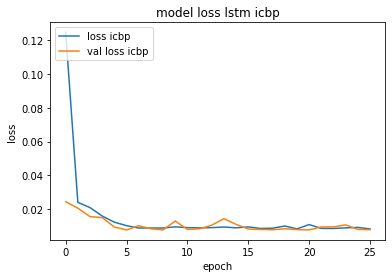

In [55]:
plt.plot(history_icbp_model.history['loss'], label='loss icbp')
plt.plot(history_icbp_model.history['val_loss'], label = 'val loss icbp')
plt.title('model loss lstm icbp')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_icbp', dpi=3600)

## JSMR

In [56]:
#get data and normalize data
df_jsmr = normalize_data(data_close.jsmr,'jsmr')
#reset index
df_jsmr = reset_index_data(df_jsmr)
#data to supervised
jsmr_X, jsmr_y = split_sequence(df_jsmr, 1)
#split to train and test
X_train_jsmr, X_test_jsmr, y_train_jsmr, y_test_jsmr = train_test_split(jsmr_X, jsmr_y, test_size=0.33, random_state=42)

X_train_jsmr = reshape_data(X_train_jsmr,1)
X_test_jsmr = reshape_data(X_test_jsmr,1)


In [57]:
# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_jsmr = [8,'relu',1,1,0.01,16,200]
model_jsmr,history_jsmr_model,  = train_vanila_lstm(X_train_jsmr,y_train_jsmr,cfg_jsmr)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 8)                 320       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
105/105 [==============================] - 2s 5ms/step - loss: 0.1872 - mae: 0.1872 - val_loss: 0.0575 - val_mae: 0.0575
Epoch 2/200
105/105 [==============================] - 0s 3ms/step - loss: 0.0274 - mae: 0.0274 - val_loss: 0.0190 - val_mae: 0.0190
Epoch 3/200
105/105 [==============================] - 0s 2ms/step - loss: 0.0209 - mae: 0.0209 - val_loss: 0.0198 - val_mae: 0.0198
Epoch 4/200
105/105 [==============================] 

In [58]:
preds_jsmr = model_jsmr.predict(X_test_jsmr)
matriks_evaluate(preds_jsmr,y_test_jsmr,'jsmr')

Matriks score for jsmr
mae score: 0.0126195277104107
r2 score 0.9936126335852742
mape score 0.03177396573719362
rmse score 0.017345499862286406


In [59]:
# Matriks score for icbp
pembulatan(0.01245784884301439
,4)
pembulatan(0.9933417201919836,4)
pembulatan(0.038401239119610214,4)
pembulatan(0.01734341193766076,4)

0.0125
0.9933
0.0384
0.0173


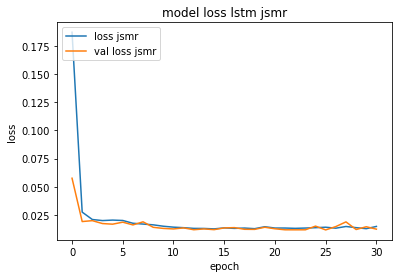

In [60]:
plt.plot(history_jsmr_model.history['loss'], label='loss jsmr')
plt.plot(history_jsmr_model.history['val_loss'], label = 'val loss jsmr')
plt.title('model loss lstm jsmr')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_jsmr', dpi=3600)

# BIDIRECTIONAL LSTM

In [61]:
def train_bidirectional_lstm(X_train,y_train,config):
    
    #unpach config
    neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_bidirectional_lstm = Sequential([
    Bidirectional(LSTM(neuron, activation=activation),input_shape=(n_steps, n_features)),
    Dense(1),
    ])
    model_bidirectional_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_bidirectional_lstm.summary()
    history_bidirectional_lstm = model_bidirectional_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_bidirectional_lstm, history_bidirectional_lstm

#time 41.8
    

## ANTM

In [62]:
cfg_antm = [8,'relu',2,1,0.1,8,200]
model_bidirectional_antm,history_antm_model_bidirectional,  = train_bidirectional_lstm(X_train_antm,y_train_antm,cfg_antm)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 16)               640       
 l)                                                              
                                                                 
 dense_10 (Dense)            (None, 1)                 17        
                                                                 
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
210/210 [==============================] - 3s 5ms/step - loss: 0.0430 - mae: 0.0430 - val_loss: 0.0218 - val_mae: 0.0218
Epoch 2/200
210/210 [==============================] - 1s 4ms/step - loss: 0.0249 - mae: 0.0249 - val_loss: 0.0118 - val_mae: 0.0118
Epoch 3/200
210/210 [==============================] - 1s 3ms/step - loss: 0.0185 - mae: 0.0185 - val_loss: 0.0233 - va

In [63]:
preds_antm_bidirectional = model_bidirectional_antm.predict(X_test_antm)
matriks_evaluate(preds_antm_bidirectional,y_test_antm,'antm')

Matriks score for antm
mae score: 0.009144362504616478
r2 score 0.9940677169465012
mape score 0.047913112048860736
rmse score 0.015123523798772938


In [64]:
# Matriks score for antm
# mae score: 0.008232755712539704
# r2 score 0.9956862906506637
# mape score 0.04528757310273332
# rmse score 0.013190786339141062

In [65]:
# Matriks score for icbp
pembulatan(0.008232755712539704
,4)
pembulatan(0.9956862906506637,4)
pembulatan(0.04528757310273332,4)
pembulatan(0.013190786339141062,4)

0.0082
0.9957
0.0453
0.0132


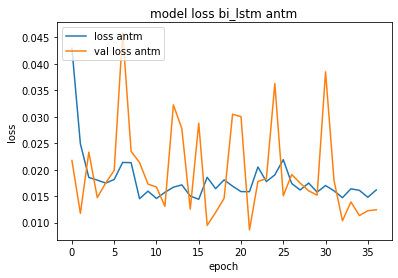

In [66]:
plt.plot(history_antm_model_bidirectional.history['loss'], label='loss antm')
plt.plot(history_antm_model_bidirectional.history['val_loss'], label = 'val loss antm')
plt.title('model loss bi_lstm antm')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_antm_bidirection', dpi=3600)

## ASII

In [67]:
cfg_asii = [32,'relu',3,1,0.01,8,150]
model_bidirectional_asii,history_asii_model_bidirectional,  = train_bidirectional_lstm(X_train_asii,y_train_asii,cfg_asii)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 64)               8704      
 nal)                                                            
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
210/210 [==============================] - 4s 5ms/step - loss: 0.0567 - mae: 0.0567 - val_loss: 0.0219 - val_mae: 0.0219
Epoch 2/150
210/210 [==============================] - 1s 4ms/step - loss: 0.0227 - mae: 0.0227 - val_loss: 0.0265 - val_mae: 0.0265
Epoch 3/150
210/210 [==============================] - 1s 4ms/step - loss: 0.0247 - mae: 0.0247 - val_loss: 0.0340 

In [68]:
preds_asii_bidirectional = model_asii.predict(X_test_asii)
matriks_evaluate(preds_asii_bidirectional,y_test_asii,'asii')

Matriks score for asii
mae score: 0.014908565628717467
r2 score 0.9902509553762698
mape score 0.03312147905833175
rmse score 0.01975851413017389


In [69]:
# Matriks score for icbp
pembulatan(0.014909980340267399
,4)
pembulatan(0.9903039901557367,4)
pembulatan(0.03413233085532062,4)
pembulatan(0.01949216813722647,4)

0.0149
0.9903
0.0341
0.0195


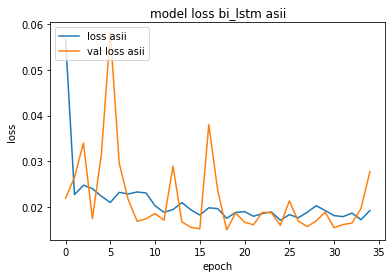

In [70]:
plt.plot(history_asii_model_bidirectional.history['loss'], label='loss asii')
plt.plot(history_asii_model_bidirectional.history['val_loss'], label = 'val loss asii')
plt.title('model loss bi_lstm asii')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_asii_bidirection', dpi=3600)

## ICBP

In [71]:
# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_icbp = [8,'relu',1,1,0.01,16,200]
model_bidirectional_icbp,history_icbp_model_bidirectional,  = train_bidirectional_lstm(X_train_icbp,y_train_icbp,cfg_icbp)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 16)               640       
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 1)                 17        
                                                                 
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
105/105 [==============================] - 6s 7ms/step - loss: 0.1401 - mae: 0.1401 - val_loss: 0.0214 - val_mae: 0.0214
Epoch 2/200
105/105 [==============================] - 0s 3ms/step - loss: 0.0212 - mae: 0.0212 - val_loss: 0.0155 - val_mae: 0.0155
Epoch 3/200
105/105 [==============================] - 0s 3ms/step - loss: 0.0160 - mae: 0.0160 - val_loss: 0.0110 - va

In [72]:
preds_icbp_bidirectional = model_icbp.predict(X_test_icbp)
matriks_evaluate(preds_icbp_bidirectional,y_test_icbp,'icbp')

Matriks score for icbp
mae score: 0.007210818142503178
r2 score 0.9983493350968135
mape score 0.028732106993582814
rmse score 0.011285054553547974


In [73]:
# Matriks score for icbp
pembulatan(0.008158403586629956
,4)
pembulatan(0.9980247438805004,4)
pembulatan(0.030377509121236643,4)
pembulatan(0.012536216195277372,4)

0.0082
0.998
0.0304
0.0125


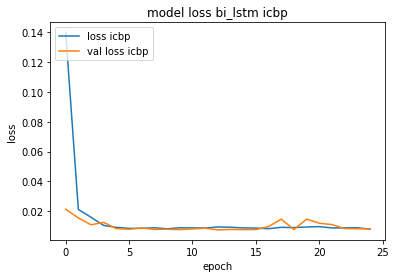

In [74]:
plt.plot(history_icbp_model_bidirectional.history['loss'], label='loss icbp')
plt.plot(history_icbp_model_bidirectional.history['val_loss'], label = 'val loss icbp')
plt.title('model loss bi_lstm icbp')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_icbp_bidirection', dpi=3600)

## JSMR

In [75]:
#get data and normalize data
df_jsmr = normalize_data(data_close.jsmr,'jsmr')
#reset index
df_jsmr = reset_index_data(df_jsmr)
#data to supervised
jsmr_X, jsmr_y = split_sequence(df_jsmr, 1)
#split to train and test
X_train_jsmr, X_test_jsmr, y_train_jsmr, y_test_jsmr = train_test_split(jsmr_X, jsmr_y, test_size=0.33, random_state=42)

X_train_jsmr = reshape_data(X_train_jsmr,1)
X_test_jsmr = reshape_data(X_test_jsmr,1)


# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_jsmr = [8,'relu',1,1,0.01,16,200]
model_bidirectional_jsmr,history_jsmr_model_bidirectional,  = train_bidirectional_lstm(X_train_jsmr,y_train_jsmr,cfg_jsmr)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 16)               640       
 nal)                                                            
                                                                 
 dense_13 (Dense)            (None, 1)                 17        
                                                                 
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
105/105 [==============================] - 3s 6ms/step - loss: 0.1208 - mae: 0.1208 - val_loss: 0.0176 - val_mae: 0.0176
Epoch 2/200
105/105 [==============================] - 0s 3ms/step - loss: 0.0193 - mae: 0.0193 - val_loss: 0.0186 - val_mae: 0.0186
Epoch 3/200
105/105 [==============================] - 0s 3ms/step - loss: 0.0180 - mae: 0.0180 - val_loss: 0.0171 - va

In [76]:
preds_jsmr_bidirectional = model_jsmr.predict(X_test_jsmr)
matriks_evaluate(preds_jsmr_bidirectional,y_test_jsmr,'jsmr')

Matriks score for jsmr
mae score: 0.0126195277104107
r2 score 0.9936126335852742
mape score 0.03177396573719362
rmse score 0.017345499862286406


In [77]:
# Matriks score for icbp
pembulatan(0.012283945702079847
,4)
pembulatan(0.9935778068483416,4)
pembulatan(0.034951478851676564,4)
pembulatan(0.017214637390602226,4)

0.0123
0.9936
0.035
0.0172


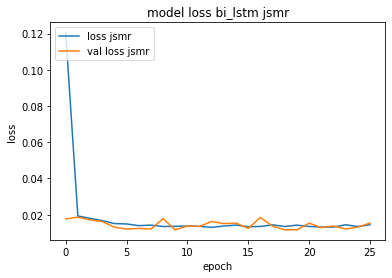

In [78]:
plt.plot(history_jsmr_model_bidirectional.history['loss'], label='loss jsmr')
plt.plot(history_jsmr_model_bidirectional.history['val_loss'], label = 'val loss jsmr')
plt.title('model loss bi_lstm jsmr')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_jsmr_bidirection', dpi=3600)

# CNN-LSTM

In [79]:
from keras.layers import Flatten 
from keras.layers import TimeDistributed 
from keras.layers.convolutional import Conv1D 
from keras.layers.convolutional import MaxPooling1D

In [80]:
def train_cnn_lstm(X_train,y_train,config):
    
    #unpach config
    neuron, activation, n_steps,n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_cnn_lstm = Sequential()
    model_cnn_lstm.add(TimeDistributed(Conv1D(64,1,activation=activation), input_shape=(None,n_steps,n_features)))
    model_cnn_lstm.add(TimeDistributed(MaxPooling1D()))
    model_cnn_lstm.add(TimeDistributed(Flatten()))
    model_cnn_lstm.add(LSTM(neuron, activation=activation))
    model_cnn_lstm.add(Dense(1))
    model_cnn_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_cnn_lstm.summary()
    history_cnn_lstm = model_cnn_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_cnn_lstm, history_cnn_lstm

#time 41.8
    

In [81]:
def reshape_data_cnn(X,N_FEATURES, N_SEQ, N_STEPS):
    X = X.reshape(X.shape[0],N_SEQ,N_STEPS,N_FEATURES)
    return X

## ANTM

In [82]:
#get data and normalize data
df_antm_cnn = normalize_data(data_close.antm,'antm')
#reset index
df_antm_cnn = reset_index_data(df_antm_cnn)
#data to supervised
antm_X_cnn, antm_y_cnn = split_sequence(df_antm_cnn, 2)
#split to train and test
X_train_antm_cnn, X_test_antm_cnn, y_train_antm_cnn, y_test_antm_cnn = train_test_split(antm_X_cnn, antm_y_cnn, test_size=0.33, random_state=44)

X_train_antm_cnn = reshape_data_cnn(X_train_antm_cnn,1,1,2)
X_test_antm_cnn = reshape_data_cnn(X_test_antm_cnn,1,1,2)

In [83]:
cfg_antm_cnn = [8,'relu',2,1,0.1,8,200]
model_cnn_antm,history_cnn_antm_model,  = train_cnn_lstm(X_train_antm_cnn,y_train_antm_cnn,cfg_antm_cnn)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 2, 64)      128       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 1, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 64)         0         
 tributed)                                                       
                                                                 
 lstm_14 (LSTM)              (None, 8)                 2336      
                                                                 
 dense_14 (Dense)            (None, 1)                 9         
                                                     

In [84]:
preds_antm_cnn_lstm = model_cnn_antm.predict(X_test_antm_cnn)
matriks_evaluate(preds_antm_cnn_lstm,y_test_antm_cnn,'antm')

Matriks score for antm
mae score: 0.009619988210030387
r2 score 0.9942479495961671
mape score 0.052720300107462176
rmse score 0.015070286517005848


In [85]:
# Matriks score for icbp
pembulatan(0.015414371122271182
,4)
pembulatan( 0.9890257070086954,4)
pembulatan(0.08284594660724198,4)
pembulatan(0.021565773748032896,4)

0.0154
0.989
0.0828
0.0216


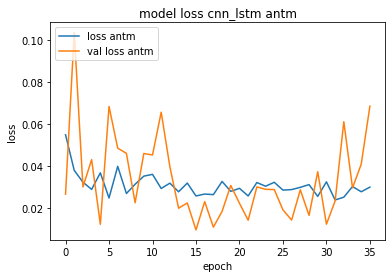

In [86]:
plt.plot(history_cnn_antm_model.history['loss'], label='loss antm')
plt.plot(history_cnn_antm_model.history['val_loss'], label = 'val loss antm')
plt.title('model loss cnn_lstm antm')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_antm_cnn', dpi=3600)

## ASII

In [87]:
#get data and normalize data
df_asii_cnn = normalize_data(data_close.asii,'asii')
#reset index
df_asii_cnn = reset_index_data(df_asii_cnn)
#data to supervised
asii_X_cnn, asii_y_cnn = split_sequence(df_asii_cnn, 3)
#split to train and test
X_train_asii_cnn, X_test_asii_cnn, y_train_asii_cnn, y_test_asii_cnn = train_test_split(asii_X_cnn, asii_y_cnn, test_size=0.33, random_state=44)

X_train_asii_cnn = reshape_data_cnn(X_train_asii_cnn,1,1,3)
X_test_asii_cnn = reshape_data_cnn(X_test_asii_cnn,1,1,3)

In [88]:
cfg_asii_cnn = [32,'relu',3,1,0.1,8,150]
model_cnn_asii,history_cnn_asii_model,  = train_cnn_lstm(X_train_asii_cnn,y_train_asii_cnn,cfg_asii_cnn)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, None, 3, 64)      128       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, None, 1, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, None, 64)         0         
 tributed)                                                       
                                                                 
 lstm_15 (LSTM)              (None, 32)                12416     
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                     

In [89]:
preds_asii_cnn_lstm = model_cnn_asii.predict(X_test_asii_cnn)
matriks_evaluate(preds_asii_cnn_lstm,y_test_asii_cnn,'asii')

Matriks score for asii
mae score: 0.15360298241915651
r2 score 0.0
mape score 0.25911537569580667
rmse score 0.19434219738058792


In [90]:
# Matriks score for icbp
pembulatan(0.16039991534697168
,4)
pembulatan(0.0
,4)
pembulatan(0.25255010186300386,4)
pembulatan( 0.20769159327531062,4)

0.1604
0.0
0.2526
0.2077


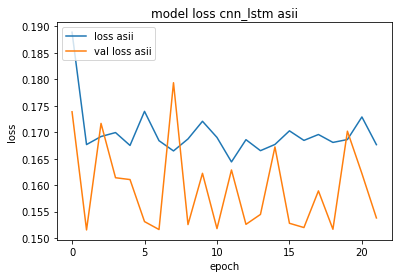

In [91]:
plt.plot(history_cnn_asii_model.history['loss'], label='loss asii')
plt.plot(history_cnn_asii_model.history['val_loss'], label = 'val loss asii')
plt.title('model loss cnn_lstm asii')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_asii_cnn', dpi=3600)

## ICBP

In [92]:
#get data and normalize data
df_icbp_cnn = normalize_data(data_close.icbp,'icbp')
#reset index
df_icbp_cnn = reset_index_data(df_icbp_cnn)
#data to supervised
icbp_X_cnn, icbp_y_cnn = split_sequence(df_icbp_cnn, 2)
#split to train and test
X_train_icbp_cnn, X_test_icbp_cnn, y_train_icbp_cnn, y_test_icbp_cnn = train_test_split(icbp_X_cnn, icbp_y_cnn, test_size=0.33, random_state=44)

X_train_icbp_cnn = reshape_data_cnn(X_train_icbp_cnn,1,1,2)
X_test_icbp_cnn = reshape_data_cnn(X_test_icbp_cnn,1,1,2)

In [93]:
cfg_icbp_cnn = [8,'relu',2,1,0.1,16,200]
model_cnn_icbp,history_cnn_icbp_model,  = train_cnn_lstm(X_train_icbp_cnn,y_train_icbp_cnn,cfg_icbp_cnn)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, None, 2, 64)      128       
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, None, 1, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, None, 64)         0         
 tributed)                                                       
                                                                 
 lstm_16 (LSTM)              (None, 8)                 2336      
                                                                 
 dense_16 (Dense)            (None, 1)                 9         
                                                     

In [94]:
preds_icbp_cnn_lstm = model_cnn_icbp.predict(X_test_icbp_cnn)
matriks_evaluate(preds_icbp_cnn_lstm,y_test_icbp_cnn,'icbp')

Matriks score for icbp
mae score: 0.011346696859806726
r2 score 0.9967718191313711
mape score 0.07381550858245217
rmse score 0.01584962328195418


In [95]:
# Matriks score for icbp
pembulatan(0.009021557054612142
,4)
pembulatan( 0.9975961517896443
,4)
pembulatan(0.05735294469845109,4)
pembulatan(0.01385724526319,4)

0.009
0.9976
0.0574
0.0139


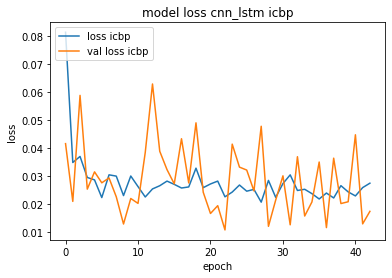

In [96]:
plt.plot(history_cnn_icbp_model.history['loss'], label='loss icbp')
plt.plot(history_cnn_icbp_model.history['val_loss'], label = 'val loss icbp')
plt.title('model loss cnn_lstm icbp')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_icbp_cnn', dpi=3600)

## JSMR

In [97]:
#get data and normalize data
df_jsmr_cnn = normalize_data(data_close.jsmr,'jsmr')
#reset index
df_jsmr_cnn = reset_index_data(df_jsmr_cnn)
#data to supervised
jsmr_X_cnn, jsmr_y_cnn = split_sequence(df_jsmr_cnn, 4)
#split to train and test
X_train_jsmr_cnn, X_test_jsmr_cnn, y_train_jsmr_cnn, y_test_jsmr_cnn = train_test_split(jsmr_X_cnn, jsmr_y_cnn, test_size=0.33, random_state=44)

X_train_jsmr_cnn = reshape_data_cnn(X_train_jsmr_cnn,1,2,2)
X_test_jsmr_cnn = reshape_data_cnn(X_test_jsmr_cnn,1,2,2)

In [98]:
cfg_jsmr_cnn = [8,'relu',2,1,0.1,16,200]
model_cnn_jsmr,history_cnn_jsmr_model,  = train_cnn_lstm(X_train_jsmr_cnn,y_train_jsmr_cnn,cfg_jsmr_cnn)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDis  (None, None, 2, 64)      128       
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, None, 1, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, None, 64)         0         
 stributed)                                                      
                                                                 
 lstm_17 (LSTM)              (None, 8)                 2336      
                                                                 
 dense_17 (Dense)            (None, 1)                 9         
                                                     

In [99]:
preds_jsmr_cnn_lstm = model_cnn_jsmr.predict(X_test_jsmr_cnn)
matriks_evaluate(preds_jsmr_cnn_lstm,y_test_jsmr_cnn,'jsmr')

Matriks score for jsmr
mae score: 0.014518581004874843
r2 score 0.9902774598644063
mape score 0.03853114392677765
rmse score 0.020561276312469196


In [100]:
# Matriks score for icbp
pembulatan(0.016145939354409146
,4)
pembulatan(0.9886551999427896
,4)
pembulatan( 0.04581825454627506,4)
pembulatan(0.02156588557280555,4)

0.0161
0.9887
0.0458
0.0216


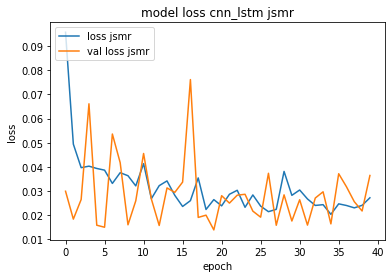

In [101]:
plt.plot(history_cnn_jsmr_model.history['loss'], label='loss jsmr')
plt.plot(history_cnn_jsmr_model.history['val_loss'], label = 'val loss jsmr')
plt.title('model loss cnn_lstm jsmr')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_jsmr_cnn', dpi=3600)

# CONVLSTM

In [102]:
def train_conv_lstm(X_train,y_train,config):
    
    #unpach config
    neuron, activation, n_steps,n_seq,n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_conv_lstm = Sequential()
    model_conv_lstm.add(ConvLSTM2D(neuron,(1,2),activation=activation, input_shape=(n_seq,1,n_steps,n_features)))
    model_conv_lstm.add(Flatten())
    model_conv_lstm.add(Dense(1))
    model_conv_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_conv_lstm.summary()
    history_conv_lstm = model_conv_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_conv_lstm, history_conv_lstm

#time 41.8
    

In [103]:
def reshape_data_conv(X,N_FEATURES, N_SEQ,N_ROWS, N_STEPS):
    X = X.reshape(X.shape[0],N_SEQ,N_ROWS,N_STEPS,N_FEATURES)
    return X

## ANTM

In [104]:
#get data and normalize data
df_antm_conv = normalize_data(data_close.antm,'antm')
#reset index
df_antm_conv = reset_index_data(df_antm_conv)
#data to supervised
antm_X_conv, antm_y_conv = split_sequence(df_antm_conv, 2)
#split to train and test
X_train_antm_conv, X_test_antm_conv, y_train_antm_conv, y_test_antm_conv = train_test_split(antm_X_conv, antm_y_conv, test_size=0.33, random_state=42)

X_train_antm_conv = reshape_data_conv(X_train_antm_conv,1,1,1,2)
X_test_antm_conv = reshape_data_conv(X_test_antm_conv,1,1,1,2)

In [105]:
cfg_antm_conv = [8,'relu',2,1,1,0.1,8,200]
model_conv_antm,history_conv_antm_model,  = train_conv_lstm(X_train_antm_conv,y_train_antm_conv,cfg_antm_conv)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 1, 8)           608       
                                                                 
 flatten_4 (Flatten)         (None, 8)                 0         
                                                                 
 dense_18 (Dense)            (None, 1)                 9         
                                                                 
Total params: 617
Trainable params: 617
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
210/210 [==============================] - 7s 8ms/step - loss: 0.0395 - mae: 0.0395 - val_loss: 0.0201 - val_mae: 0.0201
Epoch 2/200
210/210 [==============================] - 1s 5ms/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0305 - val_mae: 0.0305
Epoch 3/200
210/210 [==============================] 

In [106]:
preds_antm_conv_lstm = model_conv_antm.predict(X_test_antm_conv)
matriks_evaluate(preds_antm_conv_lstm,y_test_antm_conv,'antm')

Matriks score for antm
mae score: 0.010691036237581658
r2 score 0.9923170676433805
mape score 0.04796896394073271
rmse score 0.018437843516990855


In [107]:
# Matriks score for icbp
pembulatan(0.00899146769793364
,4)
pembulatan(0.9945626336182707
,4)
pembulatan( 0.04416493169252824,4)
pembulatan(0.014825447398887685,4)

0.009
0.9946
0.0442
0.0148


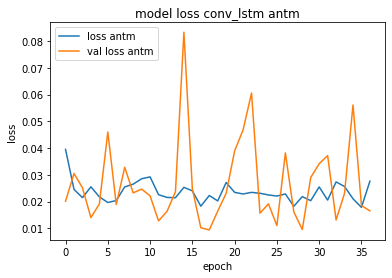

In [108]:
plt.plot(history_conv_antm_model.history['loss'], label='loss antm')
plt.plot(history_conv_antm_model.history['val_loss'], label = 'val loss antm')
plt.title('model loss conv_lstm antm')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_antm_conv', dpi=3600)

## ASII

In [109]:
#get data and normalize data
df_asii_conv = normalize_data(data_close.asii,'asii')
#reset index
df_asii_conv = reset_index_data(df_asii_conv)
#data to supervised
asii_X_conv, asii_y_conv = split_sequence(df_asii_conv, 3)
#split to train and test
X_train_asii_conv, X_test_asii_conv, y_train_asii_conv, y_test_asii_conv = train_test_split(asii_X_conv, asii_y_conv, test_size=0.33, random_state=42)

X_train_asii_conv = reshape_data_conv(X_train_asii_conv,1,1,1,3)
X_test_asii_conv = reshape_data_conv(X_test_asii_conv,1,1,1,3)

In [110]:
cfg_asii_conv = [32,'relu',3,1,1,0.1,8,150]
model_conv_asii,history_conv_asii_model,  = train_conv_lstm(X_train_asii_conv,y_train_asii_conv,cfg_asii_conv)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_1 (ConvLSTM2D)  (None, 1, 2, 32)          8576      
                                                                 
 flatten_5 (Flatten)         (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 8,641
Trainable params: 8,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
210/210 [==============================] - 4s 6ms/step - loss: 0.0747 - mae: 0.0747 - val_loss: 0.0250 - val_mae: 0.0250
Epoch 2/150
210/210 [==============================] - 1s 4ms/step - loss: 0.0402 - mae: 0.0402 - val_loss: 0.0642 - val_mae: 0.0642
Epoch 3/150
210/210 [============================

In [111]:
preds_asii_conv_lstm = model_conv_asii.predict(X_test_asii_conv)
matriks_evaluate(preds_asii_conv_lstm,y_test_asii_conv,'asii')

Matriks score for asii
mae score: 0.016750119576624336
r2 score 0.9862902226345326
mape score 0.04173809935145919
rmse score 0.023462457191942895


In [112]:
# Matriks score for icbp
pembulatan(0.016818273375650103
,4)
pembulatan(0.9857358941786828
,4)
pembulatan(0.04129176376671524,4)
pembulatan(0.023619429769432734,4)

0.0168
0.9857
0.0413
0.0236


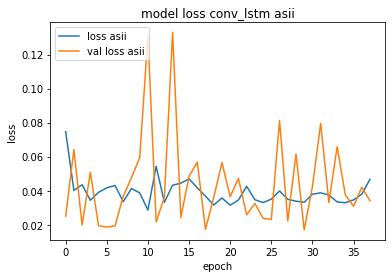

In [113]:
plt.plot(history_conv_asii_model.history['loss'], label='loss asii')
plt.plot(history_conv_asii_model.history['val_loss'], label = 'val loss asii')
plt.title('model loss conv_lstm asii')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_asii_conv', dpi=3600)

## ICBP

In [114]:
#get data and normalize data
df_icbp_conv = normalize_data(data_close.icbp,'icbp')
#reset index
df_icbp_conv = reset_index_data(df_icbp_conv)
#data to supervised
icbp_X_conv, icbp_y_conv = split_sequence(df_icbp_conv, 2)
#split to train and test
X_train_icbp_conv, X_test_icbp_conv, y_train_icbp_conv, y_test_icbp_conv = train_test_split(icbp_X_conv, icbp_y_conv, test_size=0.33, random_state=42)

X_train_icbp_conv = reshape_data_conv(X_train_icbp_conv,1,1,1,2)
X_test_icbp_conv = reshape_data_conv(X_test_icbp_conv,1,1,1,2)

In [115]:
cfg_icbp_conv = [8,'relu',2,1,1,0.1,16,200]
model_conv_icbp,history_conv_icbp_model,  = train_conv_lstm(X_train_icbp_conv,y_train_icbp_conv,cfg_icbp_conv)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_2 (ConvLSTM2D)  (None, 1, 1, 8)           608       
                                                                 
 flatten_6 (Flatten)         (None, 8)                 0         
                                                                 
 dense_20 (Dense)            (None, 1)                 9         
                                                                 
Total params: 617
Trainable params: 617
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
105/105 [==============================] - 5s 8ms/step - loss: 0.0681 - mae: 0.0681 - val_loss: 0.0172 - val_mae: 0.0172
Epoch 2/200
105/105 [==============================] - 1s 5ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0531 - val_mae: 0.0531
Epoch 3/200
105/105 [==============================] 

In [116]:
preds_icbp_conv_lstm = model_conv_icbp.predict(X_test_icbp_conv)
matriks_evaluate(preds_icbp_conv_lstm,y_test_icbp_conv,'icbp')

Matriks score for icbp
mae score: 0.00964853727988395
r2 score 0.9974729864527252
mape score 0.041529200243009566
rmse score 0.014198214433084243


In [117]:
# Matriks score for icbp
pembulatan(0.009322962515857982
,4)
pembulatan(0.997746948456813
,4)
pembulatan(0.04788248155294555,4)
pembulatan(0.013408763512437624,4)

0.0093
0.9977
0.0479
0.0134


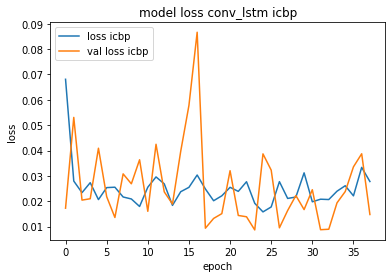

In [118]:
plt.plot(history_conv_icbp_model.history['loss'], label='loss icbp')
plt.plot(history_conv_icbp_model.history['val_loss'], label = 'val loss icbp')
plt.title('model loss conv_lstm icbp')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_icbp_conv', dpi=3600)

## JSMR

In [119]:
#get data and normalize data
df_jsmr_conv = normalize_data(data_close.jsmr,'jsmr')
#reset index
df_jsmr_conv = reset_index_data(df_jsmr_conv)
#data to supervised
jsmr_X_conv, jsmr_y_conv = split_sequence(df_jsmr_conv, 4)
#split to train and test
X_train_jsmr_conv, X_test_jsmr_conv, y_train_jsmr_conv, y_test_jsmr_conv = train_test_split(jsmr_X_conv, jsmr_y_conv, test_size=0.33, random_state=42)

X_train_jsmr_conv = reshape_data_conv(X_train_jsmr_conv,1,1,1,4)
X_test_jsmr_conv = reshape_data_conv(X_test_jsmr_conv,1,1,1,4)

In [120]:
cfg_jsmr_conv = [8,'relu',4,1,1,0.1,16,200]
model_conv_jsmr,history_conv_jsmr_model  = train_conv_lstm(X_train_jsmr_conv,y_train_jsmr_conv,cfg_jsmr_conv)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_3 (ConvLSTM2D)  (None, 1, 3, 8)           608       
                                                                 
 flatten_7 (Flatten)         (None, 24)                0         
                                                                 
 dense_21 (Dense)            (None, 1)                 25        
                                                                 
Total params: 633
Trainable params: 633
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
105/105 [==============================] - 5s 14ms/step - loss: 0.0533 - mae: 0.0533 - val_loss: 0.0195 - val_mae: 0.0195
Epoch 2/200
105/105 [==============================] - 1s 6ms/step - loss: 0.0365 - mae: 0.0365 - val_loss: 0.0374 - val_mae: 0.0374
Epoch 3/200
105/105 [==============================]

In [121]:
preds_jsmr_conv_lstm = model_conv_jsmr.predict(X_test_jsmr_conv)
matriks_evaluate(preds_jsmr_conv_lstm,y_test_jsmr_conv,'jsmr')

Matriks score for jsmr
mae score: 0.013282266441432168
r2 score 0.9922318591821051
mape score 0.041482539401250365
rmse score 0.018548364893073002


In [122]:
# Matriks score for icbp
pembulatan(0.012202475640973126
,4)
pembulatan(0.9938728499355909
,4)
pembulatan(0.037885215374269934,4)
pembulatan(0.016706095457821767,4)

0.0122
0.9939
0.0379
0.0167


In [ ]:
plt.plot(history_conv_jsmr_model.history['loss'], label='loss jsmr')
plt.plot(history_conv_jsmr_model.history['val_loss'], label = 'val loss jsmr')
plt.title('model loss conv_lstm jsmr')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_jsmr_conv', dpi=3600)

# RNN

In [123]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

def train_rnn(X_train,y_train,config):
    
    #unpach config
    neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_rnn = Sequential([
    SimpleRNN(neuron, activation=activation,input_shape=(n_steps, n_features)),
    Dense(1),
    ])
    model_rnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_rnn.summary()
    history_model_rnn = model_rnn.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_rnn, history_model_rnn

#time 41.8
    

## ANTM

In [124]:
#get data and normalize data
df_antm_rnn = normalize_data(data_close.antm,'antm')
#reset index
df_antm_rnn = reset_index_data(df_antm_rnn)
#data to supervised
antm_X_rnn, antm_y_rnn = split_sequence(df_antm_rnn, 2)
#split to train and test
X_train_antm_rnn, X_test_antm_rnn, y_train_antm_rnn, y_test_antm_rnn = train_test_split(antm_X_rnn, antm_y_rnn, test_size=0.33, random_state=42)

X_train_antm_rnn = reshape_data(X_train_antm_rnn,1)
X_test_antm_rnn = reshape_data(X_test_antm_rnn,1)


In [125]:
cfg_antm_rnn = [8,'relu',2,1,0.1,8,200]
model_antm_rnn,history_antm_model_rnn,  = train_rnn(X_train_antm,y_train_antm,cfg_antm_rnn)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 80        
                                                                 
 dense_22 (Dense)            (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
210/210 [==============================] - 2s 4ms/step - loss: 0.0425 - mae: 0.0425 - val_loss: 0.0204 - val_mae: 0.0204
Epoch 2/200
210/210 [==============================] - 1s 3ms/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0580 - val_mae: 0.0580
Epoch 3/200
210/210 [==============================] - 1s 3ms/step - loss: 0.0299 - mae: 0.0299 - val_loss: 0.0304 - val_mae: 0.0304
Epoch 4/200
210/210 [==============================] -

In [135]:
preds_antm_rnn = model_antm_rnn.predict(X_test_antm_rnn)
matriks_evaluate(preds_antm_rnn,y_test_antm_rnn,'antm')

Matriks score for antm
mae score: 0.010249852817805216
r2 score 0.9940503276707618
mape score 0.05568146334135239
rmse score 0.015257272595193957


In [139]:
# Matriks score for antm
pembulatan(0.010249852817805216,4)
pembulatan(0.9940503276707618,4)
pembulatan(0.05568146334135239,4)
pembulatan(0.01525727259519395,4)

0.0102
0.9941
0.0557
0.0153


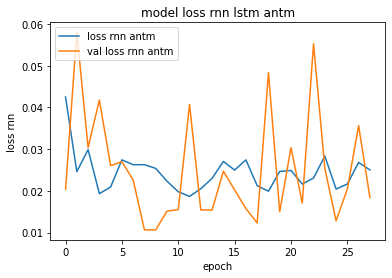

In [141]:
plt.plot(history_antm_model_rnn.history['loss'], label='loss rnn antm')
plt.plot(history_antm_model_rnn.history['val_loss'], label = 'val loss rnn antm')
plt.title('model loss rnn lstm antm')
plt.ylabel('loss rnn')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss rnn_antm', dpi=3600)

## ASII

In [126]:
#get data and normalize data
df_asii_rnn = normalize_data(data_close.asii,'asii')
#reset index
df_asii_rnn = reset_index_data(df_asii_rnn)
#data to supervised
asii_X_rnn, asii_y_rnn = split_sequence(df_asii_rnn, 3)
#split to train and test
X_train_asii_rnn, X_test_asii_rnn, y_train_asii_rnn, y_test_asii_rnn = train_test_split(asii_X_rnn, asii_y_rnn, test_size=0.33, random_state=42)

X_train_asii_rnn = reshape_data(X_train_asii_rnn,1)
X_test_asii_rnn = reshape_data(X_test_asii_rnn,1)


In [127]:
cfg_asii_rnn = [32,'relu',3,1,0.01,8,150]
model_asii_rnn,history_asii_model_rnn  = train_vanila_lstm(X_train_asii,y_train_asii,cfg_asii_rnn)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 32)                4352      
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
210/210 [==============================] - 2s 5ms/step - loss: 0.0509 - mae: 0.0509 - val_loss: 0.0179 - val_mae: 0.0179
Epoch 2/150
210/210 [==============================] - 1s 4ms/step - loss: 0.0240 - mae: 0.0240 - val_loss: 0.0219 - val_mae: 0.0219
Epoch 3/150
210/210 [==============================] - 1s 3ms/step - loss: 0.0224 - mae: 0.0224 - val_loss: 0.0281 - val_mae: 0.0281
Epoch 4/150
210/210 [===========================

In [136]:
preds_asii_rnn = model_asii_rnn.predict(X_test_asii_rnn)
matriks_evaluate(preds_asii_rnn,y_test_asii_rnn,'asii')

Matriks score for asii
mae score: 0.014864999790517417
r2 score 0.9902357018333895
mape score 0.033473036342123764
rmse score 0.019880822531293942


In [142]:
# Matriks score for antm
pembulatan(0.014864999790517417,4)
pembulatan(0.9902357018333895,4)
pembulatan(0.033473036342123764,4)
pembulatan(0.019880822531293942,4)

0.0149
0.9902
0.0335
0.0199


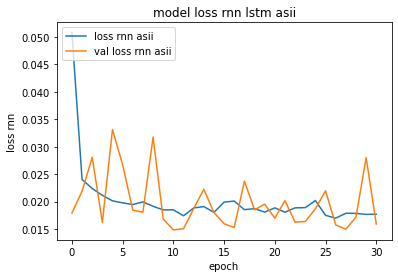

In [143]:
plt.plot(history_asii_model_rnn.history['loss'], label='loss rnn asii')
plt.plot(history_asii_model_rnn.history['val_loss'], label = 'val loss rnn asii')
plt.title('model loss rnn lstm asii')
plt.ylabel('loss rnn')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss rnn_asii', dpi=3600)

## ICBP

In [130]:
#get data and normalize data
df_icbp_rnn = normalize_data(data_close.icbp,'icbp')
#reset index
df_icbp_rnn = reset_index_data(df_icbp_rnn)
#data to supervised
icbp_X_rnn, icbp_y_rnn = split_sequence(df_icbp_rnn, 1)
#split to train and test
X_train_icbp_rnn, X_test_icbp_rnn, y_train_icbp_rnn, y_test_icbp_rnn = train_test_split(icbp_X_rnn, icbp_y_rnn, test_size=0.33, random_state=42)

X_train_icbp_rnn = reshape_data(X_train_icbp_rnn,1)
X_test_icbp_rnn = reshape_data(X_test_icbp_rnn,1)


In [132]:
cfg_icbp_rnn = [8,'relu',1,1,0.01,16,200]
model_icbp_rnn,history_icbp_model_rnn  = train_vanila_lstm(X_train_icbp,y_train_icbp,cfg_icbp_rnn)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 8)                 320       
                                                                 
 dense_26 (Dense)            (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
105/105 [==============================] - 3s 6ms/step - loss: 0.1158 - mae: 0.1158 - val_loss: 0.0197 - val_mae: 0.0197
Epoch 2/200
105/105 [==============================] - 0s 3ms/step - loss: 0.0194 - mae: 0.0194 - val_loss: 0.0153 - val_mae: 0.0153
Epoch 3/200
105/105 [==============================] - 0s 3ms/step - loss: 0.0155 - mae: 0.0155 - val_loss: 0.0104 - val_mae: 0.0104
Epoch 4/200
105/105 [==============================]

In [137]:
preds_icbp_rnn = model_icbp_rnn.predict(X_test_icbp_rnn)
matriks_evaluate(preds_icbp_rnn,y_test_icbp_rnn,'icbp')

Matriks score for icbp
mae score: 0.007314731849153852
r2 score 0.9983564285383165
mape score 0.027996778081592684
rmse score 0.011331602976987784


In [144]:
# Matriks score for antm
pembulatan(0.007314731849153852,4)
pembulatan(0.9983564285383165,4)
pembulatan(0.027996778081592684,4)
pembulatan(0.011331602976987784,4)

0.0073
0.9984
0.028
0.0113


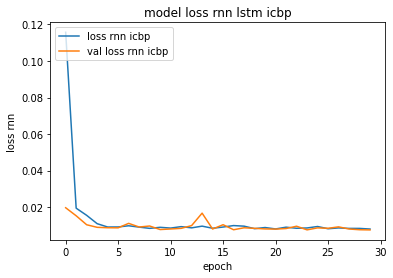

In [145]:
plt.plot(history_icbp_model_rnn.history['loss'], label='loss rnn icbp')
plt.plot(history_icbp_model_rnn.history['val_loss'], label = 'val loss rnn icbp')
plt.title('model loss rnn lstm icbp')
plt.ylabel('loss rnn')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss rnn_icbp', dpi=3600)

## JSMR

In [133]:
#get data and normalize data
df_jsmr_rnn = normalize_data(data_close.jsmr,'jsmr')
#reset index
df_jsmr_rnn = reset_index_data(df_jsmr_rnn)
#data to supervised
jsmr_X_rnn, jsmr_y_rnn = split_sequence(df_jsmr_rnn, 1)
#split to train and test
X_train_jsmr_rnn, X_test_jsmr_rnn, y_train_jsmr_rnn, y_test_jsmr_rnn = train_test_split(jsmr_X_rnn, jsmr_y_rnn, test_size=0.33, random_state=42)

X_train_jsmr_rnn = reshape_data(X_train_jsmr_rnn,1)
X_test_jsmr_rnn = reshape_data(X_test_jsmr_rnn,1)


In [134]:
cfg_jsmr_rnn = [8,'relu',1,1,0.01,16,200]
model_jsmr_rnn,history_jsmr_model_rnn  = train_vanila_lstm(X_train_jsmr,y_train_jsmr,cfg_jsmr_rnn)

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 8)                 320       
                                                                 
 dense_27 (Dense)            (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
105/105 [==============================] - 2s 6ms/step - loss: 0.2646 - mae: 0.2646 - val_loss: 0.1616 - val_mae: 0.1616
Epoch 2/200
105/105 [==============================] - 0s 3ms/step - loss: 0.1676 - mae: 0.1676 - val_loss: 0.1607 - val_mae: 0.1607
Epoch 3/200
105/105 [==============================] - 0s 3ms/step - loss: 0.1677 - mae: 0.1677 - val_loss: 0.1606 - val_mae: 0.1606
Epoch 4/200
105/105 [==============================]

In [138]:
preds_jsmr_rnn = model_jsmr_rnn.predict(X_test_jsmr_rnn)
matriks_evaluate(preds_jsmr_rnn,y_test_jsmr_rnn,'jsmr')

Matriks score for jsmr
mae score: 0.1706712099971394
r2 score -12941345046921.646
mape score 0.2890279201825068
rmse score 0.21442223198698215


In [146]:
# Matriks score for antm
pembulatan(0.1706712099971394,4)
pembulatan(-12941345046921.646,4)
pembulatan(0.2890279201825068,4)
pembulatan(0.21442223198698215,4)

0.1707
-12941345046921.646
0.289
0.2144


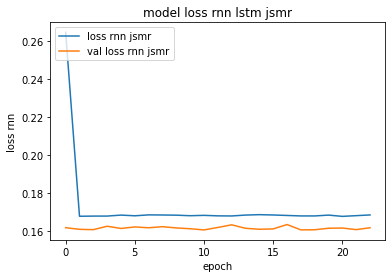

In [147]:
plt.plot(history_jsmr_model_rnn.history['loss'], label='loss rnn jsmr')
plt.plot(history_jsmr_model_rnn.history['val_loss'], label = 'val loss rnn jsmr')
plt.title('model loss rnn lstm jsmr')
plt.ylabel('loss rnn')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss rnn_jsmr', dpi=3600)

# Komparasi berdasarkan Data saham

## ANTM

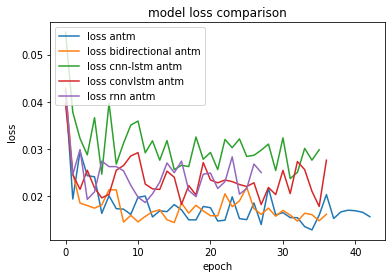

In [148]:
plt.plot(history_antm_model.history['loss'], label='loss antm')
plt.plot(history_antm_model_bidirectional.history['loss'], label='loss bidirectional antm')
plt.plot(history_cnn_antm_model.history['loss'], label='loss cnn-lstm antm')
plt.plot(history_conv_antm_model.history['loss'], label='loss convlstm antm')
plt.plot(history_antm_model_rnn.history['loss'], label='loss rnn antm')
plt.title('model loss comparison')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('lstm&rnn_loss_model_comparison_antm', dpi=3600)

## ASII

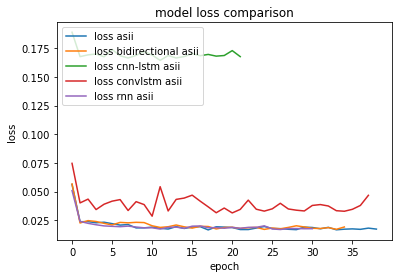

In [149]:
plt.plot(history_asii_model.history['loss'], label='loss asii')
plt.plot(history_asii_model_bidirectional.history['loss'], label='loss bidirectional asii')
plt.plot(history_cnn_asii_model.history['loss'], label='loss cnn-lstm asii')
plt.plot(history_conv_asii_model.history['loss'], label='loss convlstm asii')
plt.plot(history_asii_model_rnn.history['loss'], label='loss rnn asii')
plt.title('model loss comparison')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('lstm&rnn_loss_model_comparison_asii', dpi=3600)

## ICBP

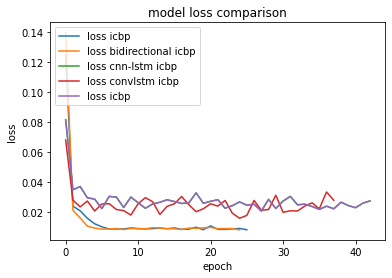

In [150]:
plt.plot(history_icbp_model.history['loss'], label='loss icbp')
plt.plot(history_icbp_model_bidirectional.history['loss'], label='loss bidirectional icbp')
plt.plot(history_cnn_icbp_model.history['loss'], label='loss cnn-lstm icbp')
plt.plot(history_conv_icbp_model.history['loss'], label='loss convlstm icbp')
plt.plot(history_cnn_icbp_model.history['loss'], label='loss icbp')
plt.title('model loss comparison')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('lstm&rnn_loss_model_comparison_icbp', dpi=3600)

## JSMR

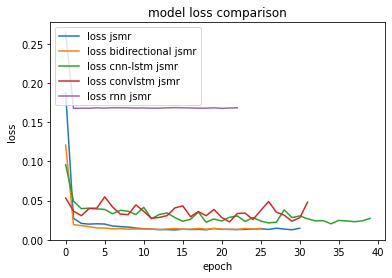

In [151]:
plt.plot(history_jsmr_model.history['loss'], label='loss jsmr')
plt.plot(history_jsmr_model_bidirectional.history['loss'], label='loss bidirectional jsmr')
plt.plot(history_cnn_jsmr_model.history['loss'], label='loss cnn-lstm jsmr')
plt.plot(history_conv_jsmr_model.history['loss'], label='loss convlstm jsmr')
plt.plot(history_jsmr_model_rnn.history['loss'], label='loss rnn jsmr')
plt.title('model loss comparison')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('lstm&rnn_loss_model_comparison_jsmr', dpi=3600)

# KOMPARASI METRIKS EVALUASI Berdasarkan saham

## ANTM

In [152]:
mae_antm_model = {'lstm_antm':mean_absolute_error(preds_antm, y_test_antm),'model_bidirectional_lstm':mean_absolute_error(preds_antm_bidirectional, y_test_antm),'model_cnn_lstm':mean_absolute_error(preds_antm_cnn_lstm, y_test_antm_cnn),'model_convlstm':mean_absolute_error(preds_antm_conv_lstm, y_test_antm_conv),'model_rnn':mean_absolute_error(preds_antm_rnn, y_test_antm_rnn)}

mape_antm_model = {'model_lstm_antm':mean_absolute_percentage_error(preds_antm, y_test_antm),'model_bidirectional_lstm':mean_absolute_percentage_error(preds_antm_bidirectional, y_test_antm),'model_cnn_lstm':mean_absolute_percentage_error(preds_antm_cnn_lstm, y_test_antm_cnn),'model_convlstm':mean_absolute_percentage_error(preds_antm_conv_lstm, y_test_antm),'model_rnn':mean_absolute_percentage_error(preds_antm_rnn, y_test_antm_rnn)}

rmse_antm_model = {'model_lstm_antm':np.sqrt(mean_squared_error(preds_antm, y_test_antm)),'model_bidirectional_lstm':np.sqrt(mean_squared_error(preds_antm_bidirectional, y_test_antm)),'model_cnn_lstm':np.sqrt(mean_squared_error(preds_antm_cnn_lstm, y_test_antm_cnn)),'model_convlstm':np.sqrt(mean_squared_error(preds_antm_conv_lstm, y_test_antm)),'model_rnn':np.sqrt(mean_squared_error(preds_antm_rnn, y_test_antm_rnn))}

r2_antm_model = {'model_lstm_antm':r2_score(preds_antm, y_test_antm),'model_bidirectional_lstm':r2_score(preds_antm_bidirectional, y_test_antm),'model_cnn_lstm':r2_score(preds_antm_cnn_lstm, y_test_antm_cnn),'model_convlstm':r2_score(preds_antm_conv_lstm, y_test_antm),'model_rnn':r2_score(preds_antm_rnn, y_test_antm_rnn)} 


In [153]:
print("sorted mae")
mae_antm_sorted = dict(sorted(mae_antm_model.items(),key=lambda item: item[1]))
print(mae_antm_sorted)
print("sorted rmse")
rmse_antm_sorted = dict(sorted(rmse_antm_model.items(),key=lambda item: item[1]))
print(rmse_antm_sorted)
print("sorted mape")
mape_antm_sorted = dict(sorted(mape_antm_model.items(),key=lambda item: item[1]))
print(mape_antm_sorted)
print("sorted r2")
r2_antm_sorted = dict(sorted(r2_antm_model.items(),key=lambda item: item[1] ,reverse=True))
print(r2_antm_sorted)

sorted mae
{'model_lstm_antm': 0.008079814308692248, 'model_bidirectional_lstm': 0.009144362504616478, 'model_cnn_lstm': 0.009619988210030387, 'model_rnn': 0.010249852817805216, 'model_convlstm': 0.010691036237581658}
sorted rmse
{'model_lstm_antm': 0.014598072272197404, 'model_cnn_lstm': 0.015070286517005848, 'model_bidirectional_lstm': 0.015123523798772938, 'model_rnn': 0.015257272595193957, 'model_convlstm': 0.018437843516990855}
sorted mape
{'model_lstm_antm': 0.04029460103718889, 'model_bidirectional_lstm': 0.047913112048860736, 'model_convlstm': 0.04796896394073271, 'model_cnn_lstm': 0.052720300107462176, 'model_rnn': 0.05568146334135239}
sorted r2
{'model_lstm_antm': 0.9945805585150753, 'model_cnn_lstm': 0.9942479495961671, 'model_bidirectional_lstm': 0.9940677169465012, 'model_rnn': 0.9940503276707618, 'model_convlstm': 0.9923170676433805}


In [154]:
# sorted mae
# {'model_lstm_antm': 0.008079814308692248, 'model_bidirectional_lstm': 0.009144362504616478, 'model_cnn_lstm': 0.009619988210030387, 'model_rnn': 0.010249852817805216, 'model_convlstm': 0.010691036237581658}
# sorted rmse
# {'model_lstm_antm': 0.014598072272197404, 'model_cnn_lstm': 0.015070286517005848, 'model_bidirectional_lstm': 0.015123523798772938, 'model_rnn': 0.015257272595193957, 'model_convlstm': 0.018437843516990855}
# sorted mape
# {'model_lstm_antm': 0.04029460103718889, 'model_bidirectional_lstm': 0.047913112048860736, 'model_convlstm': 0.04796896394073271, 'model_cnn_lstm': 0.052720300107462176, 'model_rnn': 0.05568146334135239}
# sorted r2
# {'model_lstm_antm': 0.9945805585150753, 'model_cnn_lstm': 0.9942479495961671, 'model_bidirectional_lstm': 0.9940677169465012, 'model_rnn': 0.9940503276707618, 'model_convlstm': 0.9923170676433805}

## ASII

In [155]:
mae_asii_model = {'model_lstm_asii':mean_absolute_error(preds_asii, y_test_asii),'model_bidirectional_lstm':mean_absolute_error(preds_asii_bidirectional, y_test_asii),'model_cnn_lstm':mean_absolute_error(preds_asii_cnn_lstm, y_test_asii_cnn),'model_convlstm':mean_absolute_error(preds_asii_conv_lstm, y_test_asii_conv),'model_rnn':mean_absolute_error(preds_asii_rnn, y_test_asii_rnn)}

mape_asii_model = {'model_lstm_asii':mean_absolute_percentage_error(preds_asii, y_test_asii),'model_bidirectional_lstm':mean_absolute_percentage_error(preds_asii_bidirectional, y_test_asii),'model_cnn_lstm':mean_absolute_percentage_error(preds_asii_cnn_lstm, y_test_asii_cnn),'model_convlstm':mean_absolute_percentage_error(preds_asii_conv_lstm, y_test_asii),'model_rnn':mean_absolute_percentage_error(preds_asii_rnn, y_test_asii_rnn)}

rmse_asii_model = {'model_lstm_asii':np.sqrt(mean_squared_error(preds_asii, y_test_asii)),'model_bidirectional_lstm':np.sqrt(mean_squared_error(preds_asii_bidirectional, y_test_asii)),'model_cnn_lstm':np.sqrt(mean_squared_error(preds_asii_cnn_lstm, y_test_asii_cnn)),'model_convlstm':np.sqrt(mean_squared_error(preds_asii_conv_lstm, y_test_asii)),'model_rnn':np.sqrt(mean_squared_error(preds_asii_rnn, y_test_asii_rnn))}

r2_asii_model = {'model_lstm_asii':r2_score(preds_asii, y_test_asii),'model_bidirectional_lstm':r2_score(preds_asii_bidirectional, y_test_asii),'model_cnn_lstm':r2_score(preds_asii_cnn_lstm, y_test_asii_cnn),'model_convlstm':r2_score(preds_asii_conv_lstm, y_test_asii),'model_rnn':r2_score(preds_asii_rnn, y_test_asii_rnn)} 


In [156]:
print("sorted mae")
mae_asii_sorted = dict(sorted(mae_asii_model.items(),key=lambda item: item[1]))
print(mae_asii_sorted)
print("sorted rmse")
rmse_asii_sorted = dict(sorted(rmse_asii_model.items(),key=lambda item: item[1]))
print(rmse_asii_sorted)
print("sorted mape")
mape_asii_sorted = dict(sorted(mape_asii_model.items(),key=lambda item: item[1]))
print(mape_asii_sorted)
print("sorted r2")
r2_asii_sorted = dict(sorted(r2_asii_model.items(),key=lambda item: item[1] ,reverse=True))
print(r2_asii_sorted)

sorted mae
{'model_rnn': 0.014864999790517417, 'model_lstm_asii': 0.014908565628717467, 'model_bidirectional_lstm': 0.014908565628717467, 'model_convlstm': 0.016750119576624336, 'model_cnn_lstm': 0.15360298241915651}
sorted rmse
{'model_lstm_asii': 0.01975851413017389, 'model_bidirectional_lstm': 0.01975851413017389, 'model_rnn': 0.019880822531293942, 'model_convlstm': 0.023462457191942895, 'model_cnn_lstm': 0.19434219738058792}
sorted mape
{'model_lstm_asii': 0.03312147905833175, 'model_bidirectional_lstm': 0.03312147905833175, 'model_rnn': 0.033473036342123764, 'model_convlstm': 0.04173809935145919, 'model_cnn_lstm': 0.25911537569580667}
sorted r2
{'model_lstm_asii': 0.9902509553762698, 'model_bidirectional_lstm': 0.9902509553762698, 'model_rnn': 0.9902357018333895, 'model_convlstm': 0.9862902226345326, 'model_cnn_lstm': 0.0}


In [157]:
# sorted mae
# {'model_rnn': 0.014864999790517417, 'model_lstm_asii': 0.014908565628717467, 'model_bidirectional_lstm': 0.014908565628717467, 'model_convlstm': 0.016750119576624336, 'model_cnn_lstm': 0.15360298241915651}
# sorted rmse
# {'model_lstm_asii': 0.01975851413017389, 'model_bidirectional_lstm': 0.01975851413017389, 'model_rnn': 0.019880822531293942, 'model_convlstm': 0.023462457191942895, 'model_cnn_lstm': 0.19434219738058792}
# sorted mape
# {'model_lstm_asii': 0.03312147905833175, 'model_bidirectional_lstm': 0.03312147905833175, 'model_rnn': 0.033473036342123764, 'model_convlstm': 0.04173809935145919, 'model_cnn_lstm': 0.25911537569580667}
# sorted r2
# {'model_lstm_asii': 0.9902509553762698, 'model_bidirectional_lstm': 0.9902509553762698, 'model_rnn': 0.9902357018333895, 'model_convlstm': 0.9862902226345326, 'model_cnn_lstm': 0.0}

## ICBP

In [158]:
mae_icbp_model = {'model_lstm_icbp':mean_absolute_error(preds_icbp, y_test_icbp),'model_bidirectional_lstm':mean_absolute_error(preds_icbp_bidirectional, y_test_icbp),'model_cnn_lstm':mean_absolute_error(preds_icbp_cnn_lstm, y_test_icbp_cnn),'model_convlstm':mean_absolute_error(preds_icbp_conv_lstm, y_test_icbp_conv),'model_rnn':mean_absolute_error(preds_icbp_rnn, y_test_icbp_rnn)}

mape_icbp_model = {'model_lstm_icbp':mean_absolute_percentage_error(preds_icbp, y_test_icbp),'model_bidirectional_lstm':mean_absolute_percentage_error(preds_icbp_bidirectional, y_test_icbp),'model_cnn_lstm':mean_absolute_percentage_error(preds_icbp_cnn_lstm, y_test_icbp_cnn),'model_convlstm':mean_absolute_percentage_error(preds_icbp_conv_lstm, y_test_icbp),'model_rnn':mean_absolute_percentage_error(preds_icbp_rnn, y_test_icbp_rnn)}

rmse_icbp_model = {'model_lstm_icbp':np.sqrt(mean_squared_error(preds_icbp, y_test_icbp)),'model_bidirectional_lstm':np.sqrt(mean_squared_error(preds_icbp_bidirectional, y_test_icbp)),'model_cnn_lstm':np.sqrt(mean_squared_error(preds_icbp_cnn_lstm, y_test_icbp_cnn)),'model_convlstm':np.sqrt(mean_squared_error(preds_icbp_conv_lstm, y_test_icbp)),'model_rnn':np.sqrt(mean_squared_error(preds_icbp_rnn, y_test_icbp_rnn))}

r2_icbp_model = {'model_lstm_icbp':r2_score(preds_icbp, y_test_icbp),'model_bidirectional_lstm':r2_score(preds_icbp_bidirectional, y_test_icbp),'model_cnn_lstm':r2_score(preds_icbp_cnn_lstm, y_test_icbp_cnn),'model_convlstm':r2_score(preds_icbp_conv_lstm, y_test_icbp),'model_rnn':r2_score(preds_icbp_rnn, y_test_icbp_rnn)} 


In [159]:
print("sorted mae")
mae_icbp_sorted = dict(sorted(mae_icbp_model.items(),key=lambda item: item[1]))
print(mae_icbp_sorted)
print("sorted rmse")
rmse_icbp_sorted = dict(sorted(rmse_icbp_model.items(),key=lambda item: item[1]))
print(rmse_icbp_sorted)
print("sorted mape")
mape_icbp_sorted = dict(sorted(mape_icbp_model.items(),key=lambda item: item[1]))
print(mape_icbp_sorted)
print("sorted r2")
r2_icbp_sorted = dict(sorted(r2_icbp_model.items(),key=lambda item: item[1] ,reverse=True))
print(r2_icbp_sorted)

sorted mae
{'model_lstm_icbp': 0.007210818142503178, 'model_bidirectional_lstm': 0.007210818142503178, 'model_rnn': 0.007314731849153852, 'model_convlstm': 0.00964853727988395, 'model_cnn_lstm': 0.011346696859806726}
sorted rmse
{'model_lstm_icbp': 0.011285054553547974, 'model_bidirectional_lstm': 0.011285054553547974, 'model_rnn': 0.011331602976987784, 'model_cnn_lstm': 0.01584962328195418, 'model_convlstm': 0.3642678697838057}
sorted mape
{'model_rnn': 0.027996778081592684, 'model_lstm_icbp': 0.028732106993582814, 'model_bidirectional_lstm': 0.028732106993582814, 'model_cnn_lstm': 0.07381550858245217, 'model_convlstm': 1.702764149204441}
sorted r2
{'model_rnn': 0.9983564285383165, 'model_lstm_icbp': 0.9983493350968135, 'model_bidirectional_lstm': 0.9983493350968135, 'model_cnn_lstm': 0.9967718191313711, 'model_convlstm': -0.6633430974647432}


In [160]:
# sorted mae
# {'model_lstm_icbp': 0.007210818142503178, 'model_bidirectional_lstm': 0.007210818142503178, 'model_rnn': 0.007314731849153852, 'model_convlstm': 0.00964853727988395, 'model_cnn_lstm': 0.011346696859806726}
# sorted rmse
# {'model_lstm_icbp': 0.011285054553547974, 'model_bidirectional_lstm': 0.011285054553547974, 'model_rnn': 0.011331602976987784, 'model_cnn_lstm': 0.01584962328195418, 'model_convlstm': 0.3642678697838057}
# sorted mape
# {'model_rnn': 0.027996778081592684, 'model_lstm_icbp': 0.028732106993582814, 'model_bidirectional_lstm': 0.028732106993582814, 'model_cnn_lstm': 0.07381550858245217, 'model_convlstm': 1.702764149204441}
# sorted r2
# {'model_rnn': 0.9983564285383165, 'model_lstm_icbp': 0.9983493350968135, 'model_bidirectional_lstm': 0.9983493350968135, 'model_cnn_lstm': 0.9967718191313711, 'model_convlstm': -0.6633430974647432}

## JSMR

In [161]:
print(mean_absolute_error(preds_jsmr_cnn_lstm,  y_test_jsmr_cnn))

0.014518581004874843


In [164]:
mae_jsmr_model = {'model_lstm_jsmr':mean_absolute_error(preds_jsmr, y_test_jsmr),'model_bidirectional_lstm':mean_absolute_error(preds_jsmr_bidirectional, y_test_jsmr),'model_cnn_lstm':mean_absolute_error(preds_jsmr_cnn_lstm, y_test_jsmr_cnn),'model_convlstm':mean_absolute_error(preds_jsmr_conv_lstm, y_test_jsmr_conv),'model_rnn':mean_absolute_error(preds_jsmr_rnn, y_test_jsmr_rnn)}

mape_jsmr_model = {'model_lstm_jsmr':mean_absolute_percentage_error(preds_jsmr, y_test_jsmr),'model_bidirectional_lstm':mean_absolute_percentage_error(preds_jsmr_bidirectional, y_test_jsmr),'model_cnn_lstm':mean_absolute_percentage_error(preds_jsmr_cnn_lstm, y_test_jsmr_cnn),'model_convlstm':mean_absolute_percentage_error(preds_jsmr_conv_lstm, y_test_jsmr_conv),'model_rnn':mean_absolute_percentage_error(preds_jsmr_rnn, y_test_jsmr_rnn)}

rmse_jsmr_model = {'model_lstm_jsmr':np.sqrt(mean_squared_error(preds_jsmr, y_test_jsmr)),'model_bidirectional_lstm':np.sqrt(mean_squared_error(preds_jsmr_bidirectional, y_test_jsmr)),'model_cnn_lstm':np.sqrt(mean_squared_error(preds_jsmr_cnn_lstm, y_test_jsmr_cnn)),'model_convlstm':np.sqrt(mean_squared_error(preds_jsmr_conv_lstm, y_test_jsmr_conv)),'model_rnn':np.sqrt(mean_squared_error(preds_jsmr_rnn, y_test_jsmr_rnn))}

r2_jsmr_model = {'model_lstm_jsmr':r2_score(preds_jsmr, y_test_jsmr),'model_bidirectional_lstm':r2_score(preds_jsmr_bidirectional, y_test_jsmr),'model_cnn_lstm':r2_score(preds_jsmr_cnn_lstm, y_test_jsmr_cnn),'model_convlstm':r2_score(preds_jsmr_conv_lstm, y_test_jsmr_conv),'model_rnn':r2_score(preds_jsmr_rnn, y_test_jsmr_rnn)} 


In [165]:
print("sorted mae")
mae_jsmr_sorted = dict(sorted(mae_jsmr_model.items(),key=lambda item: item[1]))
print(mae_jsmr_sorted)
print("sorted rmse")
rmse_jsmr_sorted = dict(sorted(rmse_jsmr_model.items(),key=lambda item: item[1]))
print(rmse_jsmr_sorted)
print("sorted mape")
mape_jsmr_sorted = dict(sorted(mape_jsmr_model.items(),key=lambda item: item[1]))
print(mape_jsmr_sorted)
print("sorted r2")
r2_jsmr_sorted = dict(sorted(r2_jsmr_model.items(),key=lambda item: item[1] ,reverse=True))
print(r2_jsmr_sorted)

sorted mae
{'model_lstm_jsmr': 0.0126195277104107, 'model_bidirectional_lstm': 0.0126195277104107, 'model_convlstm': 0.013282266441432168, 'model_cnn_lstm': 0.014518581004874843, 'model_rnn': 0.1706712099971394}
sorted rmse
{'model_lstm_jsmr': 0.017345499862286406, 'model_bidirectional_lstm': 0.017345499862286406, 'model_convlstm': 0.018548364893073002, 'model_cnn_lstm': 0.020561276312469196, 'model_rnn': 0.21442223198698215}
sorted mape
{'model_lstm_jsmr': 0.03177396573719362, 'model_bidirectional_lstm': 0.03177396573719362, 'model_cnn_lstm': 0.03853114392677765, 'model_convlstm': 0.041482539401250365, 'model_rnn': 0.2890279201825068}
sorted r2
{'model_lstm_jsmr': 0.9936126335852742, 'model_bidirectional_lstm': 0.9936126335852742, 'model_convlstm': 0.9922318591821051, 'model_cnn_lstm': 0.9902774598644063, 'model_rnn': -12941345046921.646}


In [ ]:
# sorted mae
# {'model_lstm_jsmr': 0.0126195277104107, 'model_bidirectional_lstm': 0.0126195277104107, 'model_convlstm': 0.013282266441432168, 'model_cnn_lstm': 0.014518581004874843, 'model_rnn': 0.1706712099971394}
# sorted rmse
# {'model_lstm_jsmr': 0.017345499862286406, 'model_bidirectional_lstm': 0.017345499862286406, 'model_convlstm': 0.018548364893073002, 'model_cnn_lstm': 0.020561276312469196, 'model_rnn': 0.21442223198698215}
# sorted mape
# {'model_lstm_jsmr': 0.03177396573719362, 'model_bidirectional_lstm': 0.03177396573719362, 'model_cnn_lstm': 0.03853114392677765, 'model_convlstm': 0.041482539401250365, 'model_rnn': 0.2890279201825068}
# sorted r2
# {'model_lstm_jsmr': 0.9936126335852742, 'model_bidirectional_lstm': 0.9936126335852742, 'model_convlstm': 0.9922318591821051, 'model_cnn_lstm': 0.9902774598644063, 'model_rnn': -12941345046921.646}

### PLOT METRIKS EVALUASI

In [216]:
def plot_metriks(data,title):
    names = list(data.keys())
    values = list(data.values())
    plt.title(title)
    plt.bar(range(len(data)), values, tick_label=names)
    plt.savefig(title, dpi=3600)
    plt.show()

#### ANTM

In [217]:
mae_antm_plot = {'mae\nlstm\nantm':mean_absolute_error(preds_antm, y_test_antm),'mae\nbidirectional\nlstm\nantm':mean_absolute_error(preds_antm_bidirectional, y_test_antm),'mae\ncnn\nlstm\nantm':mean_absolute_error(preds_antm_cnn_lstm, y_test_antm_cnn),'mae\nconvlstm\nantm':mean_absolute_error(preds_antm_conv_lstm, y_test_antm_conv),'mae\nrnn\natnm':mean_absolute_error(preds_antm_rnn, y_test_antm_rnn)}

mape_antm_plot = {'mape\nlstm\nantm':mean_absolute_percentage_error(preds_antm, y_test_antm),'mape\nbidirectional\nlstm\nantm':mean_absolute_percentage_error(preds_antm_bidirectional, y_test_antm),'mape\ncnn\nlstm\nantm':mean_absolute_percentage_error(preds_antm_cnn_lstm, y_test_antm_cnn),'mape\nconvlstm\nantm':mean_absolute_percentage_error(preds_antm_conv_lstm, y_test_antm),'mape\nrnn\nantm':mean_absolute_percentage_error(preds_antm_rnn, y_test_antm_rnn)}

rmse_antm_plot = {'rmse\nlstm\nantm':np.sqrt(mean_squared_error(preds_antm, y_test_antm)),'rmse\nbidirectional\nlstm\nantm':np.sqrt(mean_squared_error(preds_antm_bidirectional, y_test_antm)),'rmse\ncnn\nlstm\nantm':np.sqrt(mean_squared_error(preds_antm_cnn_lstm, y_test_antm_cnn)),'convlstm\nantm':np.sqrt(mean_squared_error(preds_antm_conv_lstm, y_test_antm)),'rmse\nrnn\nantm':np.sqrt(mean_squared_error(preds_antm_rnn, y_test_antm_rnn))}

r2_antm_plot = {'r2\nlstm\nantm':r2_score(preds_antm, y_test_antm),'r2\nbidirectional\nlstm\nantm':r2_score(preds_antm_bidirectional, y_test_antm),'r2\ncnn\nlstm\nantm':r2_score(preds_antm_cnn_lstm, y_test_antm_cnn),'r2\nconvlstm\nantm':r2_score(preds_antm_conv_lstm, y_test_antm),'r2\nrnn\nantm':r2_score(preds_antm_rnn, y_test_antm_rnn)} 


In [218]:
mae_antm = 'Antm Mae'
mape_antm = 'Antm Mape'
rmse_antm = 'Antm Rmse'
r2_antm = 'Antm R2'

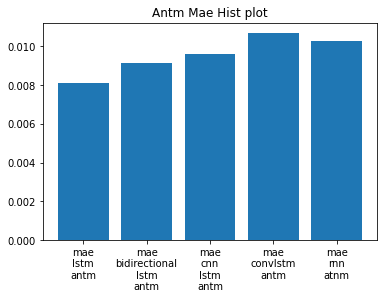

In [219]:
plot_metriks(mae_antm_plot,mae_antm + " Hist plot")

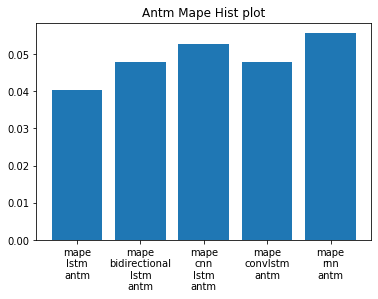

In [220]:
plot_metriks(mape_antm_plot,mape_antm + " Hist plot")

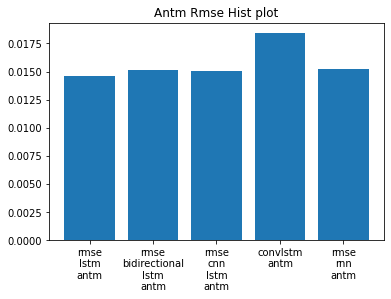

In [221]:
plot_metriks(rmse_antm_plot,rmse_antm + " Hist plot")

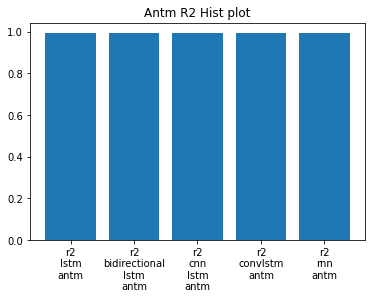

In [222]:
plot_metriks(r2_antm_plot,r2_antm +" Hist plot")

#### ASII

In [223]:
mae_asii_plot = {'mae\nlstm\nasii':mean_absolute_error(preds_asii, y_test_asii),'mae\nbidirectional\nlstm\nasii':mean_absolute_error(preds_asii_bidirectional, y_test_asii),'mae\ncnn\nlstm\nasii':mean_absolute_error(preds_asii_cnn_lstm, y_test_asii_cnn),'mae\nconvlstm\nasii':mean_absolute_error(preds_asii_conv_lstm, y_test_asii_conv),'mae\nrnn\natnm':mean_absolute_error(preds_asii_rnn, y_test_asii_rnn)}

mape_asii_plot = {'mape\nlstm\nasii':mean_absolute_percentage_error(preds_asii, y_test_asii),'mape\nbidirectional\nlstm\nasii':mean_absolute_percentage_error(preds_asii_bidirectional, y_test_asii),'mape\ncnn\nlstm\nasii':mean_absolute_percentage_error(preds_asii_cnn_lstm, y_test_asii_cnn),'mape\nconvlstm\nasii':mean_absolute_percentage_error(preds_asii_conv_lstm, y_test_asii),'mape\nrnn\nasii':mean_absolute_percentage_error(preds_asii_rnn, y_test_asii_rnn)}

rmse_asii_plot = {'rmse\nlstm\nasii':np.sqrt(mean_squared_error(preds_asii, y_test_asii)),'rmse\nbidirectional\nlstm\nasii':np.sqrt(mean_squared_error(preds_asii_bidirectional, y_test_asii)),'rmse\ncnn\nlstm\nasii':np.sqrt(mean_squared_error(preds_asii_cnn_lstm, y_test_asii_cnn)),'convlstm\nasii':np.sqrt(mean_squared_error(preds_asii_conv_lstm, y_test_asii)),'rmse\nrnn\nasii':np.sqrt(mean_squared_error(preds_asii_rnn, y_test_asii_rnn))}

r2_asii_plot = {'r2\nlstm\nasii':r2_score(preds_asii, y_test_asii),'r2\nbidirectional\nlstm\nasii':r2_score(preds_asii_bidirectional, y_test_asii),'r2\ncnn\nlstm\nasii':r2_score(preds_asii_cnn_lstm, y_test_asii_cnn),'r2\nconvlstm\nasii':r2_score(preds_asii_conv_lstm, y_test_asii),'r2\nrnn\nasii':r2_score(preds_asii_rnn, y_test_asii_rnn)} 


In [224]:
mae_asii = 'Asii Mae'
mape_asii = 'Asii Mape'
rmse_asii = 'Asii Rmse'
r2_asii = 'Asii R2'

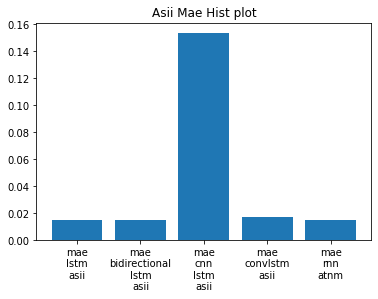

In [225]:
plot_metriks(mae_asii_plot,mae_asii + " Hist plot")

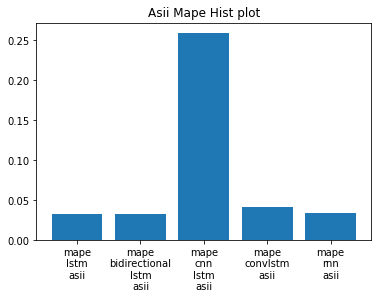

In [226]:
plot_metriks(mape_asii_plot,mape_asii + " Hist plot")

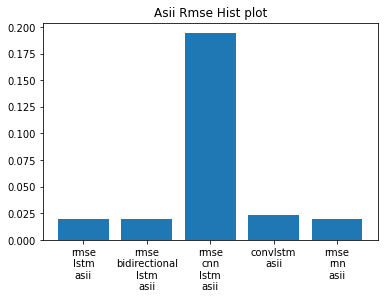

In [227]:
plot_metriks(rmse_asii_plot,rmse_asii + " Hist plot")

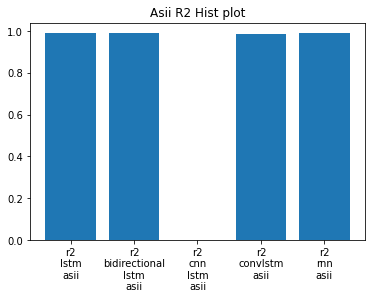

In [228]:
plot_metriks(r2_asii_plot,r2_asii +" Hist plot")

#### ICBP

In [229]:
mae_icbp_plot = {'mae\nlstm\nicbp':mean_absolute_error(preds_icbp, y_test_icbp),'mae\nbidirectional\nlstm\nicbp':mean_absolute_error(preds_icbp_bidirectional, y_test_icbp),'mae\ncnn\nlstm\nicbp':mean_absolute_error(preds_icbp_cnn_lstm, y_test_icbp_cnn),'mae\nconvlstm\nicbp':mean_absolute_error(preds_icbp_conv_lstm, y_test_icbp_conv),'mae\nrnn\natnm':mean_absolute_error(preds_icbp_rnn, y_test_icbp_rnn)}

mape_icbp_plot = {'mape\nlstm\nicbp':mean_absolute_percentage_error(preds_icbp, y_test_icbp),'mape\nbidirectional\nlstm\nicbp':mean_absolute_percentage_error(preds_icbp_bidirectional, y_test_icbp),'mape\ncnn\nlstm\nicbp':mean_absolute_percentage_error(preds_icbp_cnn_lstm, y_test_icbp_cnn),'mape\nconvlstm\nicbp':mean_absolute_percentage_error(preds_icbp_conv_lstm, y_test_icbp),'mape\nrnn\nicbp':mean_absolute_percentage_error(preds_icbp_rnn, y_test_icbp_rnn)}

rmse_icbp_plot = {'rmse\nlstm\nicbp':np.sqrt(mean_squared_error(preds_icbp, y_test_icbp)),'rmse\nbidirectional\nlstm\nicbp':np.sqrt(mean_squared_error(preds_icbp_bidirectional, y_test_icbp)),'rmse\ncnn\nlstm\nicbp':np.sqrt(mean_squared_error(preds_icbp_cnn_lstm, y_test_icbp_cnn)),'convlstm\nicbp':np.sqrt(mean_squared_error(preds_icbp_conv_lstm, y_test_icbp)),'rmse\nrnn\nicbp':np.sqrt(mean_squared_error(preds_icbp_rnn, y_test_icbp_rnn))}

r2_icbp_plot = {'r2\nlstm\nicbp':r2_score(preds_icbp, y_test_icbp),'r2\nbidirectional\nlstm\nicbp':r2_score(preds_icbp_bidirectional, y_test_icbp),'r2\ncnn\nlstm\nicbp':r2_score(preds_icbp_cnn_lstm, y_test_icbp_cnn),'r2\nconvlstm\nicbp':r2_score(preds_icbp_conv_lstm, y_test_icbp),'r2\nrnn\nicbp':r2_score(preds_icbp_rnn, y_test_icbp_rnn)} 


In [230]:
mae_icbp = 'Icbp Mae'
mape_icbp = 'Icbp Mape'
rmse_icbp = 'Icbp Rmse'
r2_icbp = 'Icbp R2'

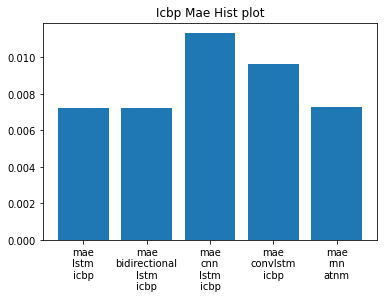

In [231]:
plot_metriks(mae_icbp_plot,mae_icbp + " Hist plot")

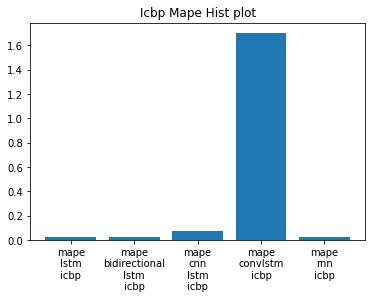

In [232]:
plot_metriks(mape_icbp_plot,mape_icbp + " Hist plot")

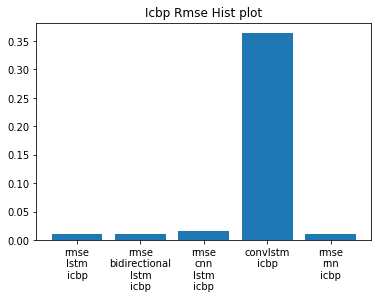

In [233]:
plot_metriks(rmse_icbp_plot,rmse_icbp + " Hist plot")

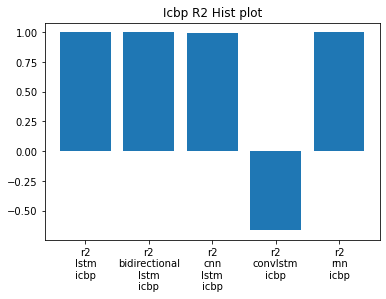

In [234]:
plot_metriks(r2_icbp_plot,r2_icbp +" Hist plot")

#### JSMR

In [235]:
mae_jsmr_plot = {'mae\nlstm\njsmr':mean_absolute_error(preds_jsmr, y_test_jsmr),'mae\nbidirectional\nlstm\njsmr':mean_absolute_error(preds_jsmr_bidirectional, y_test_jsmr),'mae\ncnn\nlstm\njsmr':mean_absolute_error(preds_jsmr_cnn_lstm, y_test_jsmr_cnn),'mae\nconvlstm\njsmr':mean_absolute_error(preds_jsmr_conv_lstm, y_test_jsmr_conv),'mae\nrnn\natnm':mean_absolute_error(preds_jsmr_rnn, y_test_jsmr_rnn)}

mape_jsmr_plot = {'mape\nlstm\njsmr':mean_absolute_percentage_error(preds_jsmr, y_test_jsmr),'mape\nbidirectional\nlstm\njsmr':mean_absolute_percentage_error(preds_jsmr_bidirectional, y_test_jsmr),'mape\ncnn\nlstm\njsmr':mean_absolute_percentage_error(preds_jsmr_cnn_lstm, y_test_jsmr_cnn),'mape\nconvlstm\njsmr':mean_absolute_percentage_error(preds_jsmr_conv_lstm, y_test_jsmr_conv),'mape\nrnn\njsmr':mean_absolute_percentage_error(preds_jsmr_rnn, y_test_jsmr_rnn)}

rmse_jsmr_plot = {'rmse\nlstm\njsmr':np.sqrt(mean_squared_error(preds_jsmr, y_test_jsmr)),'rmse\nbidirectional\nlstm\njsmr':np.sqrt(mean_squared_error(preds_jsmr_bidirectional, y_test_jsmr)),'rmse\ncnn\nlstm\njsmr':np.sqrt(mean_squared_error(preds_jsmr_cnn_lstm, y_test_jsmr_cnn)),'convlstm\njsmr':np.sqrt(mean_squared_error(preds_jsmr_conv_lstm, y_test_jsmr_conv)),'rmse\nrnn\njsmr':np.sqrt(mean_squared_error(preds_jsmr_rnn, y_test_jsmr_rnn))}

r2_jsmr_plot = {'r2\nlstm\njsmr':r2_score(preds_jsmr, y_test_jsmr),'r2\nbidirectional\nlstm\njsmr':r2_score(preds_jsmr_bidirectional, y_test_jsmr),'r2\ncnn\nlstm\njsmr':r2_score(preds_jsmr_cnn_lstm, y_test_jsmr_cnn),'r2\nconvlstm\njsmr':r2_score(preds_jsmr_conv_lstm, y_test_jsmr_conv),'r2\nrnn\njsmr':r2_score(preds_jsmr_rnn, y_test_jsmr_rnn)} 


In [236]:
mae_jsmr = 'Jsmr Mae'
mape_jsmr = 'Jsmr Mape'
rmse_jsmr = 'Jsmr Rmse'
r2_jsmr = 'Jsmr R2'

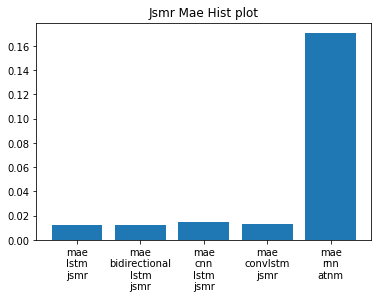

In [237]:
plot_metriks(mae_jsmr_plot,mae_jsmr + " Hist plot")

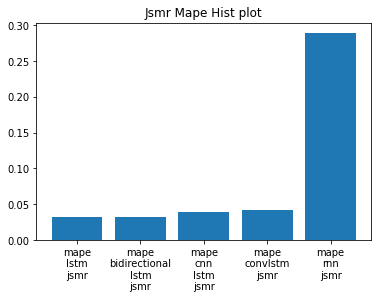

In [238]:
plot_metriks(mape_jsmr_plot,mape_jsmr + " Hist plot")

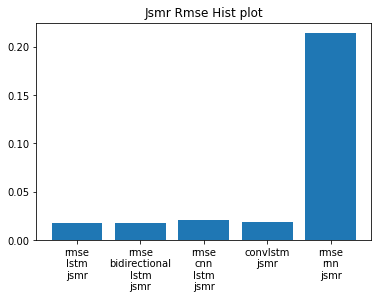

In [239]:
plot_metriks(rmse_jsmr_plot,rmse_jsmr + " Hist plot")

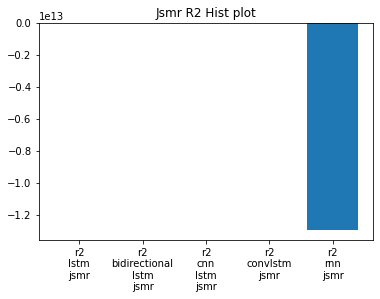

In [240]:
plot_metriks(r2_jsmr_plot,r2_jsmr +" Hist plot")